# 8장 컨볼루션을 활용한 일반화

<br>

# 8.2 컨볼루션 사용해보기

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
import collections

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

torch.set_printoptions(edgeitems=2)
torch.manual_seed(123)

import warnings
warnings.filterwarnings('ignore')

In [2]:
class_names = [
    'airplane',
    'automobile',
    'bird',
    'cat',
    'deer',
    'dog',
    'frog',
    'horse',
    'ship',
    'truck'
]

In [3]:
from torchvision import datasets, transforms

DATA_PATH = '../data/p1ch7/'

# CIFAR10 Train DATASET
cifar10 = datasets.CIFAR10(
    DATA_PATH,
    train=True,
    download=True,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(
            (0.4915, 0.4823, 0.4468),
            (0.2470, 0.2435, 0.2616)
        ),
    ]),
)

Files already downloaded and verified


In [4]:
# CIFAR10 Validation DATASET
cifar10_val = datasets.CIFAR10(
    DATA_PATH,
    train=False,
    download=True,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(
            (0.4915, 0.4823, 0.4468),
            (0.2470, 0.2435, 0.2616)
        ),
    ]),
)

Files already downloaded and verified


In [5]:
class_names = [
    'airplane',
    'bird',
]

label_map = {
    0: 0,
    2: 1,
}

cifar2 = [(img, label_map[label]) for img, label in cifar10 if label in [0, 2]]
cifar2_val = [(img, label_map[label]) for img, label in cifar10_val if label in [0, 2]]

In [6]:
connected_model = nn.Sequential(
    nn.Linear(3072, 1024),
    nn.Tanh(),
    nn.Linear(1024, 512),
    nn.Tanh(),
    nn.Linear(512, 128),
    nn.Tanh(),
    nn.Linear(128, 2)
)

In [7]:
numel_list = [p.numel() for p in connected_model.parameters() if p.requires_grad == True]

print(sum(numel_list), numel_list)

3737474 [3145728, 1024, 524288, 512, 65536, 128, 256, 2]


In [8]:
first_model = nn.Sequential(
    nn.Linear(3072, 512),
    nn.Tanh(),
    nn.Linear(512, 2),
    nn.LogSoftmax(dim=1),
)

In [9]:
numel_list = [p.numel() for p in first_model.parameters()]

print(sum(numel_list), numel_list)

1574402 [1572864, 512, 1024, 2]


In [10]:
linear = nn.Linear(3072, 1024)

print(linear.weight.shape, linear.bias.shape)

torch.Size([1024, 3072]) torch.Size([1024])


In [11]:
conv = nn.Conv2d(3, 16, kernel_size=3) # <1>
conv

Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))

In [12]:
print(conv.weight.shape, conv.bias.shape)

torch.Size([16, 3, 3, 3]) torch.Size([16])


In [13]:
img, _ = cifar2[0]
print(img.shape)

output = conv(img.unsqueeze(0))
print(img.unsqueeze(0).shape, output.shape)

torch.Size([3, 32, 32])
torch.Size([1, 3, 32, 32]) torch.Size([1, 16, 30, 30])


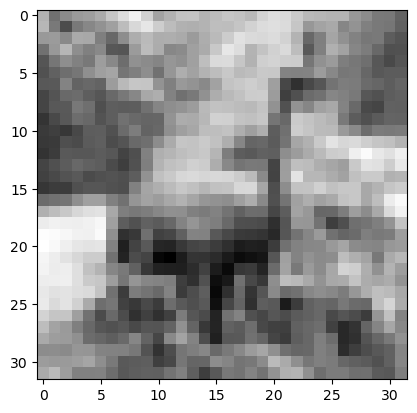

In [14]:
plt.imshow(img.mean(0), cmap='gray')
plt.show()

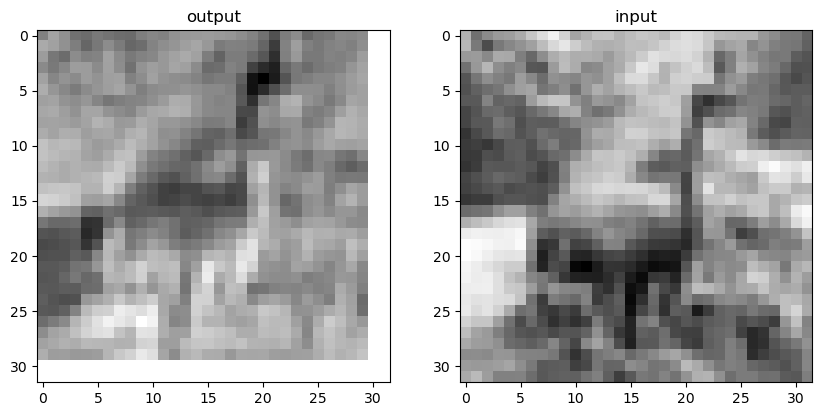

In [15]:
plt.figure(figsize=(10, 4.8))

ax1 = plt.subplot(1, 2, 1)
plt.imshow(output[0, 0].detach(), cmap='gray')
plt.title('output')

plt.subplot(1, 2, 2, sharex=ax1, sharey=ax1)
plt.imshow(img.mean(0), cmap='gray')
plt.title('input')
# plt.savefig('Ch8_F2_PyTorch.png')

plt.show()

<br>

## 8.2.1 경계 패딩하기

In [16]:
conv = nn.Conv2d(3, 1, kernel_size=3, padding=1)
output = conv(img.unsqueeze(0))

print(img.unsqueeze(0).shape, output.shape)

torch.Size([1, 3, 32, 32]) torch.Size([1, 1, 32, 32])


<br>

## 8.2.2 컨볼루션으로 피처 찾아내기

In [17]:
print(conv.bias)
print(conv.weight)

Parameter containing:
tensor([-0.0399], requires_grad=True)
Parameter containing:
tensor([[[[ 0.1495,  0.1258,  0.1452],
          [ 0.0316, -0.0064, -0.1208],
          [-0.1000, -0.0985, -0.0890]],

         [[ 0.0557, -0.0382,  0.0486],
          [-0.0164, -0.0651, -0.0177],
          [-0.1564,  0.0322, -0.0281]],

         [[ 0.1088,  0.1541, -0.0661],
          [-0.0875, -0.0608, -0.1372],
          [ 0.0527,  0.0021,  0.1692]]]], requires_grad=True)


In [18]:
with torch.no_grad():
    conv.bias.zero_()
    
with torch.no_grad():
    conv.weight.fill_(1.0 / 9.0)

print(conv.bias)
print(conv.weight)

Parameter containing:
tensor([0.], requires_grad=True)
Parameter containing:
tensor([[[[0.1111, 0.1111, 0.1111],
          [0.1111, 0.1111, 0.1111],
          [0.1111, 0.1111, 0.1111]],

         [[0.1111, 0.1111, 0.1111],
          [0.1111, 0.1111, 0.1111],
          [0.1111, 0.1111, 0.1111]],

         [[0.1111, 0.1111, 0.1111],
          [0.1111, 0.1111, 0.1111],
          [0.1111, 0.1111, 0.1111]]]], requires_grad=True)


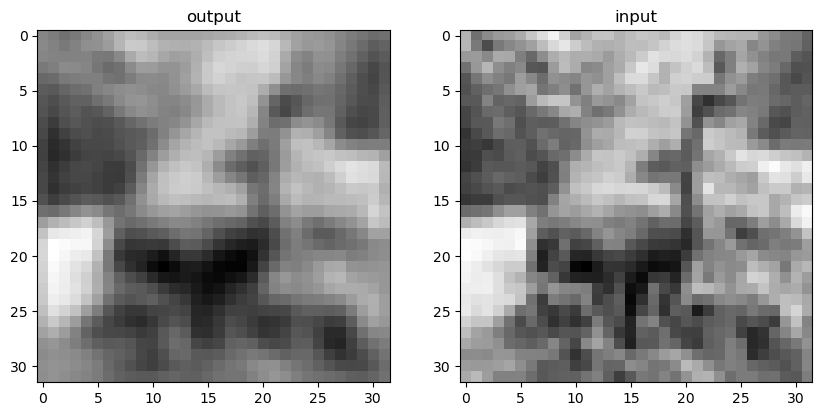

In [19]:
output = conv(img.unsqueeze(0))

plt.figure(figsize=(10, 4.8))

ax1 = plt.subplot(1, 2, 1)
plt.imshow(output[0, 0].detach(), cmap='gray')
plt.title('output')

plt.subplot(1, 2, 2, sharex=ax1, sharey=ax1)
plt.imshow(img.mean(0), cmap='gray')
plt.title('input')

# plt.savefig('Ch8_F4_PyTorch.png')
plt.show()

In [20]:
conv = nn.Conv2d(3, 1, kernel_size=3, padding=1)

with torch.no_grad():
    conv.weight[:] = torch.tensor(
        [[-1.0, 0.0, 1.0],
         [-1.0, 0.0, 1.0],
         [-1.0, 0.0, 1.0]]
    )
    conv.bias.zero_()
    
    print(conv.bias)
    print(conv.weight)

Parameter containing:
tensor([0.], requires_grad=True)
Parameter containing:
tensor([[[[-1.,  0.,  1.],
          [-1.,  0.,  1.],
          [-1.,  0.,  1.]],

         [[-1.,  0.,  1.],
          [-1.,  0.,  1.],
          [-1.,  0.,  1.]],

         [[-1.,  0.,  1.],
          [-1.,  0.,  1.],
          [-1.,  0.,  1.]]]], requires_grad=True)


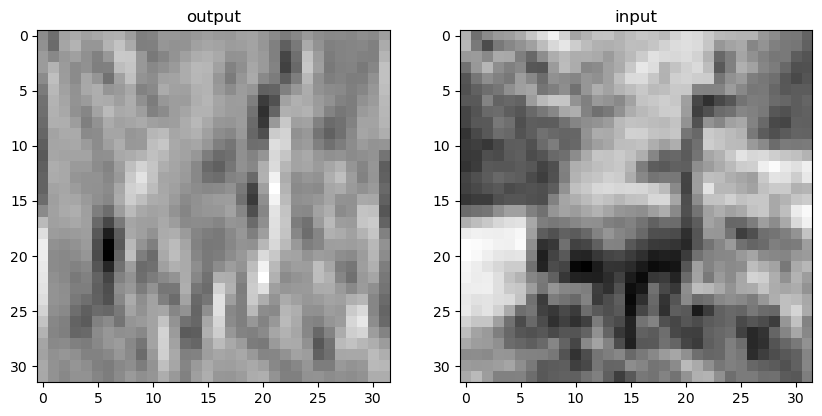

In [21]:
output = conv(img.unsqueeze(0))

plt.figure(figsize=(10, 4.8))

ax1 = plt.subplot(1, 2, 1)
plt.imshow(output[0, 0].detach(), cmap='gray')
plt.title('output')

plt.subplot(1, 2, 2, sharex=ax1, sharey=ax1)
plt.imshow(img.mean(0), cmap='gray')
plt.title('input')

# plt.savefig('Ch8_F5_PyTorch.png')
plt.show()

<br>

## 8.2.3 깊이와 풀링으로 한 단계 더 인식하기

In [22]:
pool = nn.MaxPool2d(2)
output = pool(img.unsqueeze(0))

print(img.unsqueeze(0).shape, output.shape)

torch.Size([1, 3, 32, 32]) torch.Size([1, 3, 16, 16])


<br>

## 8.2.4 우리의 신경망에 적용하기

In [23]:
model = nn.Sequential(
    nn.Conv2d(3, 16, kernel_size=3, padding=1),
    nn.Tanh(),
    nn.MaxPool2d(2),
    nn.Conv2d(16, 8, kernel_size=3, padding=1),
    nn.Tanh(),
    nn.MaxPool2d(2),
    # ...
)

In [24]:
model = nn.Sequential(
    nn.Conv2d(3, 16, kernel_size=3, padding=1),
    nn.Tanh(),
    nn.MaxPool2d(2),
    nn.Conv2d(16, 8, kernel_size=3, padding=1),
    nn.Tanh(),
    nn.MaxPool2d(2),
    # ... <1>
    nn.Linear(8 * 8 * 8, 32),
    nn.Tanh(),
    nn.Linear(32, 2)
)

In [25]:
numel_list = [p.numel() for p in model.parameters()]

print(sum(numel_list), numel_list)

18090 [432, 16, 1152, 8, 16384, 32, 64, 2]


In [26]:
model(img.unsqueeze(0))

RuntimeError: mat1 and mat2 shapes cannot be multiplied (64x8 and 512x32)

<br>

# 8.3 nn.Module 서브클래싱하기

## 8.3.1 nn.Module로 정의된 우리의 신경망

In [27]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.act1 = nn.Tanh()
        self.pool1 = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(16, 8, kernel_size=3, padding=1)
        self.act2 = nn.Tanh()
        self.pool2 = nn.MaxPool2d(2)
        self.fc1 = nn.Linear(8 * 8 * 8, 32)
        self.act3 = nn.Tanh()
        self.fc2 = nn.Linear(32, 2)

    def forward(self, x):
        out = self.pool1(self.act1(self.conv1(x)))
        out = self.pool2(self.act2(self.conv2(out)))
        out = out.view(-1, 8 * 8 * 8)
        out = self.act3(self.fc1(out))
        out = self.fc2(out)
        return out

In [28]:
model = Net()

numel_list = [p.numel() for p in model.parameters()]
print(sum(numel_list), numel_list)

18090 [432, 16, 1152, 8, 16384, 32, 64, 2]


<br>

### 8.3.3 함수형 API

In [29]:
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 8, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(8 * 8 * 8, 32)
        self.fc2 = nn.Linear(32, 2)
        
    def forward(self, x):
        out = F.max_pool2d(torch.tanh(self.conv1(x)), 2)
        out = F.max_pool2d(torch.tanh(self.conv2(out)), 2)
        out = out.view(-1, 8 * 8 * 8)
        out = torch.tanh(self.fc1(out))
        out = self.fc2(out)
        return out

In [30]:
model = Net()
model(img.unsqueeze(0))

tensor([[-0.0157,  0.1143]], grad_fn=<AddmmBackward0>)

<br>

# 8.4 우리가 만든 컨볼루션 신경망 훈련시키기

In [31]:
import datetime  # 파이썬에 포함된 datetime 모듈을 사용함

def training_loop(n_epochs, optimizer, model, loss_fn, train_loader):
    
    # 에포크 숫자는 0 대신, 1부터 n_epochs까지 루프를 돌며 부여함
    for epoch in range(1, n_epochs + 1):
        loss_train = 0.0
        
        # 데이터 로더가 만들어준 비치 안에서 데이터셋을 순회함
        for imgs, labels in train_loader:
            
            # 모델에 배치를 넣어줌
            outputs = model(imgs)
            
            # 그리고 최소화하려는 손실값을 계산
            loss = loss_fn(outputs, labels)

            # 마지막에 이전 기울기 값을 지움
            optimizer.zero_grad()
            
            #역전파 수행, 즉 신경망이 학습할 모든 파라미터에 대한 기울기를 계산함
            loss.backward()
            
            # 모델 업데이트
            optimizer.step()

            # 에포크 동안 확인한 손실값을 모두 더한다.
            # 기울기값을 꺼내고자 .item()을 사용해 손실값을
            # 파이썬 수로 변환하는 것은 중요하므로 잘 기억해두자.
            loss_train += loss.item()

        if epoch == 1 or epoch % 10 == 0:
            print(
                '{} Epoch {}, Training loss {}'.format(
                    datetime.datetime.now(),
                    epoch,
                    # 배치 단위의 평균 손실값을 구하기 위해훈련 데이터 로더의 길이로 나눈다.
                    # 이 값이 총합보다 훨씬 직관적이다.
                    loss_train / len(train_loader)
                )
            )
            

In [32]:
# DataLoader가 cifar2 데이터배치로 묶어준다.
train_loader = torch.utils.data.DataLoader(
    cifar2,
    batch_size=64,
    shuffle=True,
)

model = Net() # 신경망 초기화
optimizer = optim.SGD(model.parameters(), lr=1e-2) # 확률적 경사 하강 옵티마이저
loss_fn = nn.CrossEntropyLoss() # 크로스엔트로피 손실값

# 앞에서 정의한 훈련 루프를 호출
training_loop(
    n_epochs = 100,
    optimizer = optimizer,
    model = model,
    loss_fn = loss_fn,
    train_loader = train_loader,
)

2023-01-27 16:26:03.654677 Epoch 1, Training loss 0.5640486328844811
2023-01-27 16:26:09.960217 Epoch 10, Training loss 0.3276068071840675
2023-01-27 16:26:17.183703 Epoch 20, Training loss 0.30305799490706936
2023-01-27 16:26:24.133612 Epoch 30, Training loss 0.28095237279583696
2023-01-27 16:26:31.567238 Epoch 40, Training loss 0.26116128294331253
2023-01-27 16:26:38.734533 Epoch 50, Training loss 0.2439854476766981
2023-01-27 16:26:45.887774 Epoch 60, Training loss 0.22478863986054803
2023-01-27 16:26:53.041595 Epoch 70, Training loss 0.20537777477578753
2023-01-27 16:26:59.980470 Epoch 80, Training loss 0.1889988380442759
2023-01-27 16:27:07.087327 Epoch 90, Training loss 0.17478313130937564
2023-01-27 16:27:14.011466 Epoch 100, Training loss 0.16176195188787332


<br>

## 8.4.1 정확도 측정

In [33]:
train_loader = torch.utils.data.DataLoader(
    cifar2,
    batch_size=64,
    shuffle=False
)

val_loader = torch.utils.data.DataLoader(
    cifar2_val,
    batch_size=64,
    shuffle=False
)

def validate(model, train_loader, val_loader):
    for name, loader in [("train", train_loader), ("val", val_loader)]:
        correct = 0
        total = 0

        # 파라미터를 업데이트하지 않을 것이므로 기울기는 필요 없다.
        with torch.no_grad():
            for imgs, labels in loader:
                outputs = model(imgs)
                
                # 가장 높은 값을 가진 인덱스를 출력
                _, predicted = torch.max(outputs, dim=1)
                
                # 예제 수를 세어서 total을 배치 크기만큼 증가시킨다.
                total += labels.shape[0]
                
                # 확률값이 가장 높았던 클래스와 레이블의 실측값을 비교하여 불리언 배열을 얻고,
                # 예측값이 실측값에 맞은 경우가 배치에서 얼마나 나왔는지 세어 합한다.
                correct += int((predicted == labels).sum())

        print("Accuracy {}: {:.2f}".format(name, correct / total))

validate(model, train_loader, val_loader)

Accuracy train: 0.94
Accuracy val: 0.89


In [34]:
torch.save(model.state_dict(), DATA_PATH + 'birds_vs_airplanes.pt')

In [35]:
# 모델 상태를 저장하고 나중에 읽는 사이에, Net 정의가 바뀌지 않았는지 반드시 확인하기 바란다. 
loaded_model = Net()
loaded_model.load_state_dict(torch.load(DATA_PATH + 'birds_vs_airplanes.pt'))

<All keys matched successfully>

<br>

## 8.4.3 GPU에서 훈련시키기

In [36]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(f"Training on device {device}.")

Training on device cuda.


In [37]:
import datetime

def training_loop(n_epochs, optimizer, model, loss_fn, train_loader):
    for epoch in range(1, n_epochs + 1):
        loss_train = 0.0
        for imgs, labels in train_loader:
            
            # imgs, labels를 옮기는 이 두 줄만 이전과 다르다.
            imgs = imgs.to(device=device)
            labels = labels.to(device=device)
            
            outputs = model(imgs)
            loss = loss_fn(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            loss_train += loss.item()

        if epoch == 1 or epoch % 10 == 0:
            print('{} Epoch {}, Training loss {}'.format(
                    datetime.datetime.now(),
                    epoch,
                    loss_train / len(train_loader)))

In [38]:
train_loader = torch.utils.data.DataLoader(
    cifar2,
    batch_size=64,
    shuffle=True
)

# 모델(파라미터)을 GPU로 옮긴다.
# 모델이나 입력을 GPU로 옮기지 않으면 파이토치는 GPU와 CPU 입력을 섞어 실행하는 연산을 지원하지 않으므로
# '동일 디바이스에 존재하지 않음' 에러가 발생한다.
model = Net().to(device=device)
optimizer = optim.SGD(model.parameters(), lr=1e-2)
loss_fn = nn.CrossEntropyLoss()

training_loop(
    n_epochs = 100,
    optimizer = optimizer,
    model = model,
    loss_fn = loss_fn,
    train_loader = train_loader,
)

2023-01-27 16:27:16.818563 Epoch 1, Training loss 0.5758700220827844
2023-01-27 16:27:18.011848 Epoch 10, Training loss 0.3257263388223709
2023-01-27 16:27:19.341711 Epoch 20, Training loss 0.2901758140154705
2023-01-27 16:27:20.666551 Epoch 30, Training loss 0.26727523668936104
2023-01-27 16:27:21.979452 Epoch 40, Training loss 0.2481022294444643
2023-01-27 16:27:23.285089 Epoch 50, Training loss 0.22971907946144698
2023-01-27 16:27:24.574071 Epoch 60, Training loss 0.2152218448033758
2023-01-27 16:27:25.875045 Epoch 70, Training loss 0.1996031236259421
2023-01-27 16:27:27.175746 Epoch 80, Training loss 0.1854162009990519
2023-01-27 16:27:28.466062 Epoch 90, Training loss 0.16807623449594353
2023-01-27 16:27:29.774426 Epoch 100, Training loss 0.15627510157550217


In [39]:
train_loader = torch.utils.data.DataLoader(
    cifar2,
    batch_size=64,
    shuffle=False
)

val_loader = torch.utils.data.DataLoader(
    cifar2_val,
    batch_size=64,
    shuffle=False
)

all_acc_dict = collections.OrderedDict()

def validate(model, train_loader, val_loader):
    accdict = {}
    for name, loader in [("train", train_loader), ("val", val_loader)]:
        correct = 0
        total = 0

        with torch.no_grad():
            for imgs, labels in loader:
                imgs = imgs.to(device=device)
                labels = labels.to(device=device)
                outputs = model(imgs)
                _, predicted = torch.max(outputs, dim=1)
                total += labels.shape[0]
                correct += int((predicted == labels).sum())

        print("Accuracy {}: {:.2f}".format(name , correct / total))
        accdict[name] = correct / total
    return accdict

all_acc_dict["baseline"] = validate(model, train_loader, val_loader)

Accuracy train: 0.92
Accuracy val: 0.89


In [40]:
loaded_model = Net().to(device=device)

loaded_model.load_state_dict(
    torch.load(
        DATA_PATH + 'birds_vs_airplanes.pt',
        map_location=device
    )
)

<All keys matched successfully>

<br>

# 8.5 모델 설계

## 8.5.1 메모리 용량 늘리기: 너비

In [41]:
class NetWidth(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 16, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(16 * 8 * 8, 32)
        self.fc2 = nn.Linear(32, 2)
        
    def forward(self, x):
        out = F.max_pool2d(torch.tanh(self.conv1(x)), 2)
        out = F.max_pool2d(torch.tanh(self.conv2(out)), 2)
        out = out.view(-1, 16 * 8 * 8)
        out = torch.tanh(self.fc1(out))
        out = self.fc2(out)
        return out

In [42]:
model = NetWidth().to(device=device)
optimizer = optim.SGD(model.parameters(), lr=1e-2)
loss_fn = nn.CrossEntropyLoss()

training_loop(
    n_epochs = 100,
    optimizer = optimizer,
    model = model,
    loss_fn = loss_fn,
    train_loader = train_loader,
)

validate(
    model,
    train_loader,
    val_loader
)

2023-01-27 16:27:30.417942 Epoch 1, Training loss 0.5593288493384222
2023-01-27 16:27:31.958878 Epoch 10, Training loss 0.31846904223132283
2023-01-27 16:27:33.645024 Epoch 20, Training loss 0.27623631990259623
2023-01-27 16:27:35.332953 Epoch 30, Training loss 0.2390860630923016
2023-01-27 16:27:37.023741 Epoch 40, Training loss 0.20706390679641895
2023-01-27 16:27:38.711809 Epoch 50, Training loss 0.17924570909161477
2023-01-27 16:27:40.403724 Epoch 60, Training loss 0.15459800193643874
2023-01-27 16:27:42.094094 Epoch 70, Training loss 0.1318009281234377
2023-01-27 16:27:43.779621 Epoch 80, Training loss 0.11059261856090491
2023-01-27 16:27:45.480101 Epoch 90, Training loss 0.09145866757982475
2023-01-27 16:27:47.186395 Epoch 100, Training loss 0.07480797214303048
Accuracy train: 0.97
Accuracy val: 0.90


{'train': 0.9738, 'val': 0.898}

In [43]:
class NetWidth(nn.Module):
    def __init__(self, n_chans1=32):
        super().__init__()
        self.n_chans1 = n_chans1
        self.conv1 = nn.Conv2d(3, n_chans1, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(n_chans1, n_chans1 // 2, kernel_size=3,
                               padding=1)
        self.fc1 = nn.Linear(8 * 8 * n_chans1 // 2, 32)
        self.fc2 = nn.Linear(32, 2)
        
    def forward(self, x):
        out = F.max_pool2d(torch.tanh(self.conv1(x)), 2)
        out = F.max_pool2d(torch.tanh(self.conv2(out)), 2)
        out = out.view(-1, 8 * 8 * self.n_chans1 // 2)
        out = torch.tanh(self.fc1(out))
        out = self.fc2(out)
        return out

In [44]:
model = NetWidth(n_chans1=32).to(device=device)
optimizer = optim.SGD(model.parameters(), lr=1e-2)
loss_fn = nn.CrossEntropyLoss()

training_loop(
    n_epochs = 100,
    optimizer = optimizer,
    model = model,
    loss_fn = loss_fn,
    train_loader = train_loader,
)

all_acc_dict["width"] = validate(
    model,
    train_loader,
    val_loader
)

2023-01-27 16:27:47.681905 Epoch 1, Training loss 0.5685802238761999
2023-01-27 16:27:49.203917 Epoch 10, Training loss 0.3152115648719156
2023-01-27 16:27:50.894304 Epoch 20, Training loss 0.2709001127132185
2023-01-27 16:27:52.596525 Epoch 30, Training loss 0.23595246069940032
2023-01-27 16:27:54.291889 Epoch 40, Training loss 0.2080189115872049
2023-01-27 16:27:55.985488 Epoch 50, Training loss 0.1841175342631188
2023-01-27 16:27:57.689595 Epoch 60, Training loss 0.16073294567644217
2023-01-27 16:27:59.393856 Epoch 70, Training loss 0.13764861316248111
2023-01-27 16:28:01.119970 Epoch 80, Training loss 0.11569851506382796
2023-01-27 16:28:02.845481 Epoch 90, Training loss 0.09574250488951327
2023-01-27 16:28:04.540736 Epoch 100, Training loss 0.07788282378938548
Accuracy train: 0.97
Accuracy val: 0.88


In [45]:
sum(p.numel() for p in model.parameters())

38386

<br>

## 8.5.2 모델이 수렴하고 일반화하도록 돕는 방법 : 정규화

### 파라미터 제어하기: 가중치 페널티

In [46]:
def training_loop_l2reg(
    n_epochs,
    optimizer,
    model,
    loss_fn,
    train_loader
):
    for epoch in range(1, n_epochs + 1):
        loss_train = 0.0
        for imgs, labels in train_loader:
            imgs = imgs.to(device=device)
            labels = labels.to(device=device)
            outputs = model(imgs)
            loss = loss_fn(outputs, labels)
            
            # L1 정규화라면 pow(2.0)을 abs()로 바꾼다.
            l2_lambda = 0.001
            l2_norm = sum(p.pow(2.0).sum()
                          for p in model.parameters())
            loss = loss + l2_lambda * l2_norm

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            loss_train += loss.item()
        if epoch == 1 or epoch % 10 == 0:
            print('{} Epoch {}, Training loss {}'.format(
                datetime.datetime.now(),
                epoch,
                loss_train / len(train_loader)))

In [47]:
model = Net().to(device=device)
optimizer = optim.SGD(model.parameters(), lr=1e-2)
loss_fn = nn.CrossEntropyLoss()

training_loop_l2reg(
    n_epochs = 100,
    optimizer = optimizer,
    model = model,
    loss_fn = loss_fn,
    train_loader = train_loader,
)

all_acc_dict["l2 reg"] = validate(
    model,
    train_loader,
    val_loader
)

2023-01-27 16:28:05.251190 Epoch 1, Training loss 0.5981728161216542
2023-01-27 16:28:06.826350 Epoch 10, Training loss 0.374394282888455
2023-01-27 16:28:08.560949 Epoch 20, Training loss 0.33436037353269615
2023-01-27 16:28:10.264276 Epoch 30, Training loss 0.30822616397954855
2023-01-27 16:28:12.009937 Epoch 40, Training loss 0.2882175446505759
2023-01-27 16:28:13.739938 Epoch 50, Training loss 0.27208719606612136
2023-01-27 16:28:15.461198 Epoch 60, Training loss 0.2580120954543922
2023-01-27 16:28:17.187906 Epoch 70, Training loss 0.245444980159307
2023-01-27 16:28:18.906516 Epoch 80, Training loss 0.2340920135663573
2023-01-27 16:28:20.647246 Epoch 90, Training loss 0.22380199283361435
2023-01-27 16:28:22.341717 Epoch 100, Training loss 0.21402802275624244
Accuracy train: 0.92
Accuracy val: 0.88


### 입력 하나에 너무 의존하지 않기 : 드랍아웃

In [48]:
class NetDropout(nn.Module):
    def __init__(self, n_chans1=32):
        super().__init__()
        self.n_chans1 = n_chans1
        self.conv1 = nn.Conv2d(3, n_chans1, kernel_size=3, padding=1)
        self.conv1_dropout = nn.Dropout2d(p=0.4)
        self.conv2 = nn.Conv2d(n_chans1, n_chans1 // 2, kernel_size=3, padding=1)
        self.conv2_dropout = nn.Dropout2d(p=0.4)
        self.fc1 = nn.Linear(8 * 8 * n_chans1 // 2, 32)
        self.fc2 = nn.Linear(32, 2)
        
    def forward(self, x):
        out = F.max_pool2d(torch.tanh(self.conv1(x)), 2)
        out = self.conv1_dropout(out)
        out = F.max_pool2d(torch.tanh(self.conv2(out)), 2)
        out = self.conv2_dropout(out)
        out = out.view(-1, 8 * 8 * self.n_chans1 // 2)
        out = torch.tanh(self.fc1(out))
        out = self.fc2(out)
        return out

In [49]:
model = NetDropout(n_chans1=32).to(device=device)
optimizer = optim.SGD(model.parameters(), lr=1e-2)
loss_fn = nn.CrossEntropyLoss()

training_loop(
    n_epochs = 100,
    optimizer = optimizer,
    model = model,
    loss_fn = loss_fn,
    train_loader = train_loader,
)

all_acc_dict["dropout"] = validate(
    model,
    train_loader,
    val_loader
)

2023-01-27 16:28:22.823579 Epoch 1, Training loss 0.5780786461890883
2023-01-27 16:28:24.414079 Epoch 10, Training loss 0.3772763275796441
2023-01-27 16:28:26.206012 Epoch 20, Training loss 0.3505858256938351
2023-01-27 16:28:27.972245 Epoch 30, Training loss 0.3326818312808966
2023-01-27 16:28:29.749782 Epoch 40, Training loss 0.3154066738429343
2023-01-27 16:28:31.520804 Epoch 50, Training loss 0.30376316179895096
2023-01-27 16:28:33.285815 Epoch 60, Training loss 0.2902558863542642
2023-01-27 16:28:35.043611 Epoch 70, Training loss 0.2850144384962738
2023-01-27 16:28:36.805246 Epoch 80, Training loss 0.27020422108234116
2023-01-27 16:28:38.570832 Epoch 90, Training loss 0.26078987112090846
2023-01-27 16:28:40.354074 Epoch 100, Training loss 0.24008776959340283
Accuracy train: 0.90
Accuracy val: 0.88


### 활성 함수 억제하기 : 배치 정규화

In [50]:
class NetBatchNorm(nn.Module):
    def __init__(self, n_chans1=32):
        super().__init__()
        self.n_chans1 = n_chans1
        self.conv1 = nn.Conv2d(3, n_chans1, kernel_size=3, padding=1)
        self.conv1_batchnorm = nn.BatchNorm2d(num_features=n_chans1)
        self.conv2 = nn.Conv2d(n_chans1, n_chans1 // 2, kernel_size=3, padding=1)
        self.conv2_batchnorm = nn.BatchNorm2d(num_features=n_chans1 // 2)
        self.fc1 = nn.Linear(8 * 8 * n_chans1 // 2, 32)
        self.fc2 = nn.Linear(32, 2)
        
    def forward(self, x):
        out = self.conv1_batchnorm(self.conv1(x))
        out = F.max_pool2d(torch.tanh(out), 2)
        out = self.conv2_batchnorm(self.conv2(out))
        out = F.max_pool2d(torch.tanh(out), 2)
        out = out.view(-1, 8 * 8 * self.n_chans1 // 2)
        out = torch.tanh(self.fc1(out))
        out = self.fc2(out)
        return out

In [51]:
model = NetBatchNorm(n_chans1=32).to(device=device)
optimizer = optim.SGD(model.parameters(), lr=1e-2)
loss_fn = nn.CrossEntropyLoss()

training_loop(
    n_epochs = 100,
    optimizer = optimizer,
    model = model,
    loss_fn = loss_fn,
    train_loader = train_loader,
)

all_acc_dict["batch_norm"] = validate(
    model,
    train_loader,
    val_loader
)

2023-01-27 16:28:40.918843 Epoch 1, Training loss 0.45454326518781624
2023-01-27 16:28:42.839304 Epoch 10, Training loss 0.26556986551375905
2023-01-27 16:28:44.974025 Epoch 20, Training loss 0.20099997776708786
2023-01-27 16:28:47.106407 Epoch 30, Training loss 0.1512889123646317
2023-01-27 16:28:49.227121 Epoch 40, Training loss 0.10809855976966536
2023-01-27 16:28:51.351274 Epoch 50, Training loss 0.07323250528069059
2023-01-27 16:28:53.480450 Epoch 60, Training loss 0.05440318509699053
2023-01-27 16:28:55.618510 Epoch 70, Training loss 0.03130577027702787
2023-01-27 16:28:57.765970 Epoch 80, Training loss 0.0347912885296117
2023-01-27 16:28:59.896571 Epoch 90, Training loss 0.012351585455701515
2023-01-27 16:29:02.028655 Epoch 100, Training loss 0.007979547713177314
Accuracy train: 0.99
Accuracy val: 0.88


<br>

## 8.5.3 더 복잡한 구조를 배우기 위해 깊이 파헤치기: 깊이

### 스킵 커넥션

In [52]:
class NetDepth(nn.Module):
    def __init__(self, n_chans1=32):
        super().__init__()
        self.n_chans1 = n_chans1
        self.conv1 = nn.Conv2d(3, n_chans1, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(n_chans1, n_chans1 // 2, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(n_chans1 // 2, n_chans1 // 2, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(4 * 4 * n_chans1 // 2, 32)
        self.fc2 = nn.Linear(32, 2)
        
    def forward(self, x):
        out = F.max_pool2d(torch.relu(self.conv1(x)), 2)
        out = F.max_pool2d(torch.relu(self.conv2(out)), 2)
        out = F.max_pool2d(torch.relu(self.conv3(out)), 2)
        out = out.view(-1, 4 * 4 * self.n_chans1 // 2)
        out = torch.relu(self.fc1(out))
        out = self.fc2(out)
        return out

In [53]:
model = NetDepth(n_chans1=32).to(device=device)
optimizer = optim.SGD(model.parameters(), lr=1e-2)
loss_fn = nn.CrossEntropyLoss()

training_loop(
    n_epochs = 100,
    optimizer = optimizer,
    model = model,
    loss_fn = loss_fn,
    train_loader = train_loader,
)

all_acc_dict["depth"] = validate(
    model,
    train_loader,
    val_loader
)

2023-01-27 16:29:02.543943 Epoch 1, Training loss 0.677388366620252
2023-01-27 16:29:04.276402 Epoch 10, Training loss 0.345475447026028
2023-01-27 16:29:06.216476 Epoch 20, Training loss 0.29766683774009634
2023-01-27 16:29:08.140651 Epoch 30, Training loss 0.2671347186443912
2023-01-27 16:29:10.050913 Epoch 40, Training loss 0.23896545285631896
2023-01-27 16:29:11.977000 Epoch 50, Training loss 0.2102965623804718
2023-01-27 16:29:13.908302 Epoch 60, Training loss 0.18278457874515255
2023-01-27 16:29:15.836981 Epoch 70, Training loss 0.15698260094994193
2023-01-27 16:29:17.768615 Epoch 80, Training loss 0.13169189320675506
2023-01-27 16:29:19.690868 Epoch 90, Training loss 0.10742650776626958
2023-01-27 16:29:21.614101 Epoch 100, Training loss 0.0859142113892231
Accuracy train: 0.93
Accuracy val: 0.89


In [54]:
class NetRes(nn.Module):
    def __init__(self, n_chans1=32):
        super().__init__()
        self.n_chans1 = n_chans1
        self.conv1 = nn.Conv2d(3, n_chans1, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(n_chans1, n_chans1 // 2, kernel_size=3,padding=1)
        self.conv3 = nn.Conv2d(n_chans1 // 2, n_chans1 // 2, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(4 * 4 * n_chans1 // 2, 32)
        self.fc2 = nn.Linear(32, 2)
        
    def forward(self, x):
        out = F.max_pool2d(torch.relu(self.conv1(x)), 2)
        out = F.max_pool2d(torch.relu(self.conv2(out)), 2)
        out1 = out
        out = F.max_pool2d(torch.relu(self.conv3(out)) + out1, 2)
        out = out.view(-1, 4 * 4 * self.n_chans1 // 2)
        out = torch.relu(self.fc1(out))
        out = self.fc2(out)
        return out

In [55]:
model = NetRes(n_chans1=32).to(device=device)
optimizer = optim.SGD(model.parameters(), lr=1e-2)
loss_fn = nn.CrossEntropyLoss()

training_loop(
    n_epochs = 100,
    optimizer = optimizer,
    model = model,
    loss_fn = loss_fn,
    train_loader = train_loader,
)

all_acc_dict["res"] = validate(
    model,
    train_loader,
    val_loader
)

2023-01-27 16:29:22.216351 Epoch 1, Training loss 0.6149452723515262
2023-01-27 16:29:23.971519 Epoch 10, Training loss 0.3253330011276682
2023-01-27 16:29:25.899764 Epoch 20, Training loss 0.2762456380637588
2023-01-27 16:29:27.838181 Epoch 30, Training loss 0.2403817331525171
2023-01-27 16:29:29.778735 Epoch 40, Training loss 0.20654239353670437
2023-01-27 16:29:31.728544 Epoch 50, Training loss 0.17685755603252704
2023-01-27 16:29:33.672982 Epoch 60, Training loss 0.1494946575421057
2023-01-27 16:29:35.605298 Epoch 70, Training loss 0.12258398084408918
2023-01-27 16:29:37.540510 Epoch 80, Training loss 0.09685873362431481
2023-01-27 16:29:39.477019 Epoch 90, Training loss 0.07562626384578314
2023-01-27 16:29:41.407244 Epoch 100, Training loss 0.055611611243076384
Accuracy train: 0.97
Accuracy val: 0.89


### 파이토치로 매우 깊은 모델 만들기

In [56]:
class ResBlock(nn.Module):
    def __init__(self, n_chans):
        super(ResBlock, self).__init__()
        # BatchNorm 계층은 편향값의 효과를 상쇄하므로, 관례상 이를 생략한다.
        self.conv = nn.Conv2d(n_chans, n_chans, kernel_size=3, padding=1, bias=False)
        self.batch_norm = nn.BatchNorm2d(num_features=n_chans)
        
        #커스텀 초기화.
        # .kaiming_normal_은 레즈넷 논문에서처럼 표준편차를 가지는 표준 랜덤 요소로 초기화해준다.
        # 배치 정규화는 기본값으로 평균 0과 분산 0.5를 가지는 분포의 출력을 만들도록 초기화한다.
        torch.nn.init.kaiming_normal_(self.conv.weight, nonlinearity='relu')
        torch.nn.init.constant_(self.batch_norm.weight, 0.5)
        torch.nn.init.zeros_(self.batch_norm.bias)

    def forward(self, x):
        out = self.conv(x)
        out = self.batch_norm(out)
        out = torch.relu(out)
        return out + x

In [57]:
class NetResDeep(nn.Module):
    def __init__(self, n_chans1=32, n_blocks=10):
        super().__init__()
        self.n_chans1 = n_chans1
        self.conv1 = nn.Conv2d(3, n_chans1, kernel_size=3, padding=1)
        self.resblocks = nn.Sequential(
            *(n_blocks * [ResBlock(n_chans=n_chans1)])
        )
        self.fc1 = nn.Linear(8 * 8 * n_chans1, 32)
        self.fc2 = nn.Linear(32, 2)
        
    def forward(self, x):
        out = F.max_pool2d(torch.relu(self.conv1(x)), 2)
        out = self.resblocks(out)
        out = F.max_pool2d(out, 2)
        out = out.view(-1, 8 * 8 * self.n_chans1)
        out = torch.relu(self.fc1(out))
        out = self.fc2(out)
        return out

In [58]:
model = NetResDeep(n_chans1=32, n_blocks=100).to(device=device)
optimizer = optim.SGD(model.parameters(), lr=3e-3)
loss_fn = nn.CrossEntropyLoss()

training_loop(
    n_epochs = 100,
    optimizer = optimizer,
    model = model,
    loss_fn = loss_fn,
    train_loader = train_loader,
)

all_acc_dict["res deep"] = validate(
    model,
    train_loader,
    val_loader
)

2023-01-27 16:29:51.363778 Epoch 1, Training loss 1.4833676492332653
2023-01-27 16:31:17.306023 Epoch 10, Training loss 0.27671837977543
2023-01-27 16:32:52.790328 Epoch 20, Training loss 0.19498354281969132
2023-01-27 16:34:28.274492 Epoch 30, Training loss 0.13590885172034525
2023-01-27 16:36:03.757722 Epoch 40, Training loss 0.09886880587952532
2023-01-27 16:37:39.244625 Epoch 50, Training loss 0.09186698732286644
2023-01-27 16:39:14.729172 Epoch 60, Training loss 0.04157183960281834
2023-01-27 16:40:50.206323 Epoch 70, Training loss 0.0488621369360169
2023-01-27 16:42:25.688788 Epoch 80, Training loss 0.10288590248555514
2023-01-27 16:44:01.169146 Epoch 90, Training loss 0.10198954566957275
2023-01-27 16:45:36.651464 Epoch 100, Training loss 0.07139166665951585
Accuracy train: 0.87
Accuracy val: 0.83


<br>

## 8.5.4 모델의 성능 비교

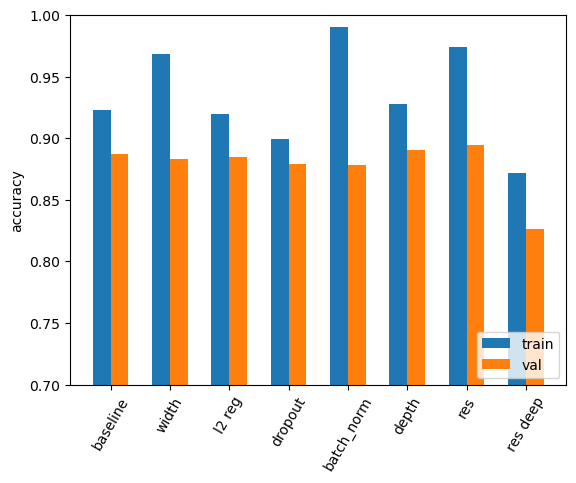

In [59]:
trn_acc = [v['train'] for k, v in all_acc_dict.items()]
val_acc = [v['val'] for k, v in all_acc_dict.items()]

width =0.3
plt.bar(np.arange(len(trn_acc)), trn_acc, width=width, label='train')
plt.bar(np.arange(len(val_acc))+ width, val_acc, width=width, label='val')
plt.xticks(np.arange(len(val_acc))+ width/2, list(all_acc_dict.keys()), rotation=60)
plt.ylabel('accuracy')
plt.legend(loc='lower right')
plt.ylim(0.7, 1)
plt.savefig('accuracy_comparison.png', bbox_inches='tight')
plt.show()